# RSNA2024 LSDC Training Baseline
In the [previous notebook](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-making-dataset), We selected the images we wanted to use and exported them to png.

This notebook will use those images for training.

- version 1 to 5 are old versions
- version 6 is fixed something about validation metrics
- version 7 is used efn-b3

### My other Notebooks
- [RSNA2024 LSDC Making Dataset](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-making-dataset) 
- [RSNA2024 LSDC Training Baseline](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-training-baseline) <- you're reading now
- [RSNA2024 LSDC Submission Baseline](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-submission-baseline)

# Import Libralies

In [1]:
!unzip -q /kaggle/input/rsna2024-lsdc-making-dataset/_output_.zip 

In [2]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold

In [3]:
rd = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'

# Config

In [4]:
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost

OUTPUT_DIR = f'rsna24-results'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = os.cpu_count() 
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IMG_SIZE = [512, 512]
IN_CHANS = 30
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75

N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 20 if NOT_DEBUG else 2
MODEL_NAME = "tf_efficientnet_b3.ns_jft_in1k" if NOT_DEBUG else "tf_efficientnet_b0.ns_jft_in1k"

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 3

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

# Open Dataframes

In [7]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


Change the state to Label.

The dataframe contains some Nans, which we will replace with -100 so that We and function can ignore them when calculating the loss and score.

In [8]:
df = df.fillna(-100)

In [9]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_24/1901592955.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

# Define Dataset

This implementation is very slow and leaves a lot of room for improvement.

In [11]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((512, 512, IN_CHANS), dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1
        for i in range(0, 10, 1):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T1/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T1')
                pass
            
        # Sagittal T2/STIR
        for i in range(0, 10, 1):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T2_STIR/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass
            
        # Axial T2
        axt2 = glob(f'./cvt_png/{st_id}/Axial T2/*.png')
        axt2 = sorted(axt2)
    
        step = len(axt2) / 10.0
        st = len(axt2)/2.0 - 4.0*step
        end = len(axt2)+0.0001
                
        for i, j in enumerate(np.arange(st, end, step)):
            try:
                p = axt2[max(0, int((j-0.5001).round()))]
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass  
            
        assert np.sum(x)>0
            
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)
                
        return x, label

# Define Data Augmentaion
Data augmentation is important because the number of images used for training is extremely small.
See [this notebook](https://www.kaggle.com/code/haqishen/1st-place-soluiton-code-small-ver) by [Qishen Ha](https://www.kaggle.com/haqishen) for help setting up this augmentation.

In [12]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


# Trying Data Loader
Checking if the data loader works properly.

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.9529) tensor(-0.5578) tensor(0.3555)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


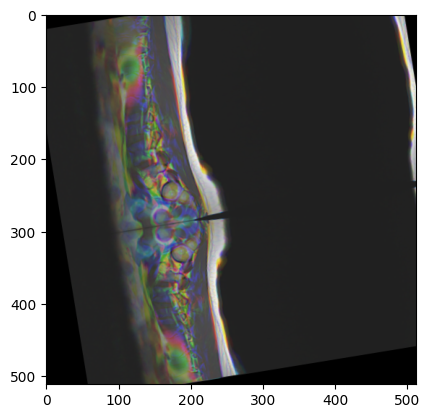

y stat: (512, 512, 3) 0.0 0.96470594 0.19110608 0.1515823

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.9922) tensor(-0.6914) tensor(0.3289)
tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]) torch.Size([1, 25])


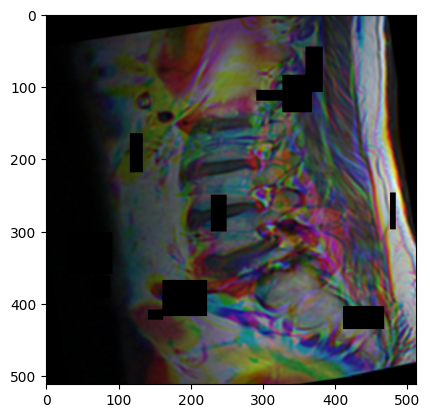

y stat: (512, 512, 3) 0.0 0.99215686 0.21368925 0.18514155

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.6149) tensor(0.4740)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


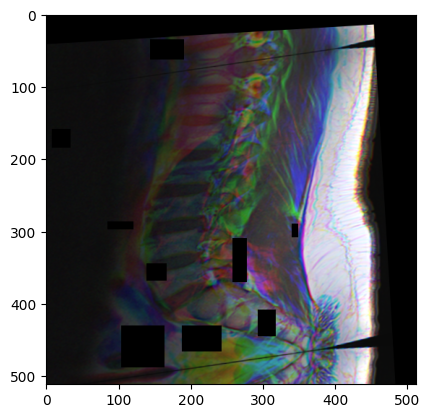

y stat: (512, 512, 3) 0.0 1.0 0.22478418 0.25545746

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.9451) tensor(-0.8532) tensor(0.2262)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


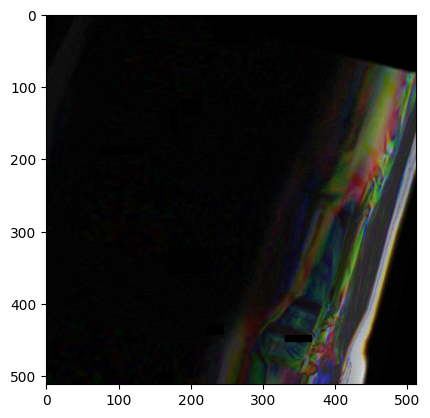

y stat: (512, 512, 3) 0.0 0.8745098 0.06554954 0.119752176

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.4275) tensor(-0.7558) tensor(0.2792)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0]]) torch.Size([1, 25])


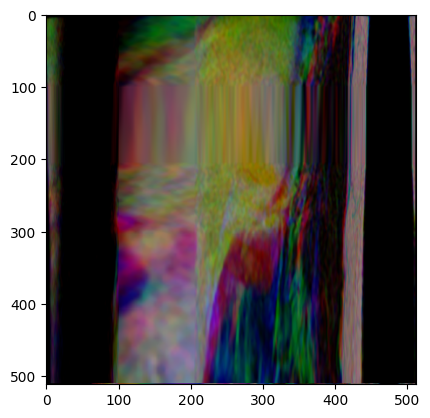

y stat: (512, 512, 3) 0.0 0.7137255 0.20142125 0.19563746



In [13]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            num_workers=0
            )

for i, (x, t) in enumerate(tmp_dl):
    if i==5:break
    print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)
    y = x.numpy().transpose(0,2,3,1)[0,...,:3]
    y = (y + 1) / 2
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()
del tmp_ds, tmp_dl

# Define Model
We use timm, which is commonly used for image classification.

In [14]:
class RSNA24Model(nn.Module):
    def __init__(self, model_name, in_c=30, n_classes=75, pretrained=True, features_only=False):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained, 
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )
    
    def forward(self, x):
        y = self.model(x)
        return y

# Testing Model
Checking if the model works properly.

In [15]:
m = RSNA24Model(MODEL_NAME, in_c=IN_CHANS, n_classes=N_CLASSES, pretrained=False)
i = torch.randn(2, IN_CHANS, 512, 512)
out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

torch.Size([75]) tensor(-1.1601, grad_fn=<MinBackward1>) tensor(1.2260, grad_fn=<MaxBackward1>)
torch.Size([75]) tensor(-0.8702, grad_fn=<MinBackward1>) tensor(0.7158, grad_fn=<MaxBackward1>)


In [16]:
del m, i, out

# Train loop

In [17]:
#autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # if your gpu is newer Ampere, you can use this, lesser appearance of nan than half
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))
    df_train = df.iloc[trn_idx]
    df_valid = df.iloc[val_idx]

    train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
    train_dl = DataLoader(
                train_ds,
                batch_size=BATCH_SIZE,
                shuffle=True,
                pin_memory=True,
                drop_last=True,
                num_workers=N_WORKERS
                )

    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=BATCH_SIZE*2,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
    num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
    num_cycles = 0.475
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warmup_steps,
                                                num_training_steps=num_total_steps,
                                                num_cycles=num_cycles)

    weights = torch.tensor([1.0, 2.0, 4.0])
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    criterion2 = nn.CrossEntropyLoss(weight=weights)

    best_loss = 1.2
    best_wll = 1.2
    es_step = 0

    for epoch in range(1, EPOCHS+1):
        print(f'start epoch {epoch}')
        model.train()
        total_loss = 0
        with tqdm(train_dl, leave=True) as pbar:
            optimizer.zero_grad()
            for idx, (x, t) in enumerate(pbar):  
                x = x.to(device)
                t = t.to(device)
                
                with autocast:
                    loss = 0
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col]
                        loss = loss + criterion(pred, gt) / N_LABELS
                        
                    total_loss += loss.item()
                    if GRAD_ACC > 1:
                        loss = loss / GRAD_ACC
    
                if not math.isfinite(loss):
                    print(f"Loss is {loss}, stopping training")
                    sys.exit(1)
    
                pbar.set_postfix(
                    OrderedDict(
                        loss=f'{loss.item()*GRAD_ACC:.6f}',
                        lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                    )
                )
                scaler.scale(loss).backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)
                
                if (idx + 1) % GRAD_ACC == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    if scheduler is not None:
                        scheduler.step()                    
    
        train_loss = total_loss/len(train_dl)
        print(f'train_loss:{train_loss:.6f}')

        total_loss = 0
        y_preds = []
        labels = []
        
        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    
                    x = x.to(device)
                    t = t.to(device)
                        
                    with autocast:
                        loss = 0
                        loss_ema = 0
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]
 
                            loss = loss + criterion(pred, gt) / N_LABELS
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())
                        
                        total_loss += loss.item()   
    
        val_loss = total_loss/len(valid_dl)
        
        y_preds = torch.cat(y_preds, dim=0)
        labels = torch.cat(labels)
        val_wll = criterion2(y_preds, labels)
        
        print(f'val_loss:{val_loss:.6f}, val_wll:{val_wll:.6f}')

        if val_loss < best_loss or val_wll < best_wll:
            
            es_step = 0

            if device!='cuda:0':
                model.to('cuda:0')                
                
            if val_loss < best_loss:
                print(f'epoch:{epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
                best_loss = val_loss
                
            if val_wll < best_wll:
                print(f'epoch:{epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
                best_wll = val_wll
                fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
                torch.save(model.state_dict(), fname)
            
            if device!='cuda:0':
                model.to(device)
            
        else:
            es_step += 1
            if es_step >= EARLY_STOPPING_EPOCH:
                print('early stopping')
                break  
                                

##############################
start fold0
##############################
1580 395


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

start epoch 1


100%|██████████| 98/98 [05:26<00:00,  3.33s/it, loss=0.807885, lr=9.796e-05]


train_loss:1.003731


100%|██████████| 13/13 [01:16<00:00,  5.87s/it]


val_loss:0.843391, val_wll:0.893725
epoch:1, best loss updated from 1.200000 to 0.843391
epoch:1, best wll_metric updated from 1.200000 to 0.893725
start epoch 2


100%|██████████| 98/98 [05:10<00:00,  3.16s/it, loss=0.682945, lr=1.980e-04]


train_loss:0.782045


100%|██████████| 13/13 [01:13<00:00,  5.63s/it]


val_loss:0.746268, val_wll:0.805564
epoch:2, best loss updated from 0.843391 to 0.746268
epoch:2, best wll_metric updated from 0.893725 to 0.805564
start epoch 3


100%|██████████| 98/98 [04:54<00:00,  3.00s/it, loss=0.603615, lr=1.987e-04]


train_loss:0.738729


100%|██████████| 13/13 [01:19<00:00,  6.09s/it]


val_loss:0.713942, val_wll:0.768268
epoch:3, best loss updated from 0.746268 to 0.713942
epoch:3, best wll_metric updated from 0.805564 to 0.768268
start epoch 4


100%|██████████| 98/98 [04:52<00:00,  2.99s/it, loss=0.731091, lr=1.947e-04]


train_loss:0.700461


100%|██████████| 13/13 [01:14<00:00,  5.72s/it]


val_loss:0.693645, val_wll:0.755178
epoch:4, best loss updated from 0.713942 to 0.693645
epoch:4, best wll_metric updated from 0.768268 to 0.755178
start epoch 5


100%|██████████| 98/98 [04:57<00:00,  3.04s/it, loss=0.855945, lr=1.880e-04]


train_loss:0.671114


100%|██████████| 13/13 [01:17<00:00,  6.00s/it]


val_loss:0.683390, val_wll:0.740856
epoch:5, best loss updated from 0.693645 to 0.683390
epoch:5, best wll_metric updated from 0.755178 to 0.740856
start epoch 6


100%|██████████| 98/98 [05:02<00:00,  3.09s/it, loss=0.718131, lr=1.790e-04]


train_loss:0.654689


100%|██████████| 13/13 [01:14<00:00,  5.74s/it]


val_loss:0.676889, val_wll:0.729337
epoch:6, best loss updated from 0.683390 to 0.676889
epoch:6, best wll_metric updated from 0.740856 to 0.729337
start epoch 7


100%|██████████| 98/98 [05:09<00:00,  3.16s/it, loss=0.675756, lr=1.678e-04]


train_loss:0.633643


100%|██████████| 13/13 [01:34<00:00,  7.25s/it]


val_loss:0.661021, val_wll:0.715774
epoch:7, best loss updated from 0.676889 to 0.661021
epoch:7, best wll_metric updated from 0.729337 to 0.715774
start epoch 8


100%|██████████| 98/98 [05:00<00:00,  3.07s/it, loss=0.602752, lr=1.547e-04]


train_loss:0.620780


100%|██████████| 13/13 [01:33<00:00,  7.18s/it]


val_loss:0.666961, val_wll:0.723551
start epoch 9


100%|██████████| 98/98 [05:06<00:00,  3.13s/it, loss=0.577496, lr=1.402e-04]


train_loss:0.602546


100%|██████████| 13/13 [01:42<00:00,  7.91s/it]


val_loss:0.657660, val_wll:0.713121
epoch:9, best loss updated from 0.661021 to 0.657660
epoch:9, best wll_metric updated from 0.715774 to 0.713121
start epoch 10


100%|██████████| 98/98 [05:12<00:00,  3.19s/it, loss=0.572388, lr=1.245e-04]


train_loss:0.592089


100%|██████████| 13/13 [01:32<00:00,  7.14s/it]


val_loss:0.656185, val_wll:0.710840
epoch:10, best loss updated from 0.657660 to 0.656185
epoch:10, best wll_metric updated from 0.713121 to 0.710840
start epoch 11


100%|██████████| 98/98 [05:06<00:00,  3.12s/it, loss=0.509719, lr=1.082e-04]


train_loss:0.570426


100%|██████████| 13/13 [01:41<00:00,  7.80s/it]


val_loss:0.656704, val_wll:0.712664
start epoch 12


100%|██████████| 98/98 [05:03<00:00,  3.09s/it, loss=0.564136, lr=9.162e-05]


train_loss:0.555421


100%|██████████| 13/13 [01:24<00:00,  6.49s/it]


val_loss:0.669843, val_wll:0.727612
start epoch 13


100%|██████████| 98/98 [04:53<00:00,  2.99s/it, loss=0.482120, lr=7.529e-05]


train_loss:0.538257


100%|██████████| 13/13 [01:31<00:00,  7.03s/it]


val_loss:0.667928, val_wll:0.726363
early stopping
##############################
start fold1
##############################
1580 395
start epoch 1


100%|██████████| 98/98 [05:01<00:00,  3.08s/it, loss=0.769217, lr=9.796e-05]


train_loss:1.000816


100%|██████████| 13/13 [01:27<00:00,  6.72s/it]


val_loss:0.829665, val_wll:0.885526
epoch:1, best loss updated from 1.200000 to 0.829665
epoch:1, best wll_metric updated from 1.200000 to 0.885526
start epoch 2


100%|██████████| 98/98 [05:01<00:00,  3.08s/it, loss=0.821528, lr=1.980e-04]


train_loss:0.770913


100%|██████████| 13/13 [01:21<00:00,  6.23s/it]


val_loss:0.766055, val_wll:0.821130
epoch:2, best loss updated from 0.829665 to 0.766055
epoch:2, best wll_metric updated from 0.885526 to 0.821130
start epoch 3


100%|██████████| 98/98 [05:05<00:00,  3.11s/it, loss=0.707703, lr=1.987e-04]


train_loss:0.724803


100%|██████████| 13/13 [01:29<00:00,  6.91s/it]


val_loss:0.722046, val_wll:0.780805
epoch:3, best loss updated from 0.766055 to 0.722046
epoch:3, best wll_metric updated from 0.821130 to 0.780805
start epoch 4


100%|██████████| 98/98 [04:54<00:00,  3.00s/it, loss=0.784444, lr=1.947e-04]


train_loss:0.689241


100%|██████████| 13/13 [01:20<00:00,  6.18s/it]


val_loss:0.709500, val_wll:0.767710
epoch:4, best loss updated from 0.722046 to 0.709500
epoch:4, best wll_metric updated from 0.780805 to 0.767710
start epoch 5


100%|██████████| 98/98 [05:01<00:00,  3.08s/it, loss=0.607342, lr=1.880e-04]


train_loss:0.665878


100%|██████████| 13/13 [01:07<00:00,  5.18s/it]


val_loss:0.697158, val_wll:0.748669
epoch:5, best loss updated from 0.709500 to 0.697158
epoch:5, best wll_metric updated from 0.767710 to 0.748669
start epoch 6


100%|██████████| 98/98 [05:00<00:00,  3.06s/it, loss=0.619222, lr=1.790e-04]


train_loss:0.640575


100%|██████████| 13/13 [01:29<00:00,  6.85s/it]


val_loss:0.687829, val_wll:0.737748
epoch:6, best loss updated from 0.697158 to 0.687829
epoch:6, best wll_metric updated from 0.748669 to 0.737748
start epoch 7


100%|██████████| 98/98 [04:55<00:00,  3.02s/it, loss=0.558909, lr=1.678e-04]


train_loss:0.620675


100%|██████████| 13/13 [01:43<00:00,  7.93s/it]


val_loss:0.686298, val_wll:0.739056
epoch:7, best loss updated from 0.687829 to 0.686298
start epoch 8


100%|██████████| 98/98 [04:58<00:00,  3.05s/it, loss=0.613144, lr=1.547e-04]


train_loss:0.608795


100%|██████████| 13/13 [01:20<00:00,  6.20s/it]


val_loss:0.689850, val_wll:0.739223
start epoch 9


100%|██████████| 98/98 [04:58<00:00,  3.05s/it, loss=0.579717, lr=1.402e-04]


train_loss:0.595130


100%|██████████| 13/13 [01:16<00:00,  5.87s/it]


val_loss:0.684955, val_wll:0.739023
epoch:9, best loss updated from 0.686298 to 0.684955
start epoch 10


100%|██████████| 98/98 [05:04<00:00,  3.11s/it, loss=0.661188, lr=1.245e-04]


train_loss:0.580326


100%|██████████| 13/13 [01:23<00:00,  6.42s/it]


val_loss:0.680265, val_wll:0.730120
epoch:10, best loss updated from 0.684955 to 0.680265
epoch:10, best wll_metric updated from 0.737748 to 0.730120
start epoch 11


100%|██████████| 98/98 [05:00<00:00,  3.07s/it, loss=0.717720, lr=1.082e-04]


train_loss:0.561506


100%|██████████| 13/13 [01:28<00:00,  6.77s/it]


val_loss:0.701394, val_wll:0.757320
start epoch 12


100%|██████████| 98/98 [04:54<00:00,  3.00s/it, loss=0.558912, lr=9.162e-05]


train_loss:0.547096


100%|██████████| 13/13 [01:36<00:00,  7.44s/it]


val_loss:0.689511, val_wll:0.740098
start epoch 13


100%|██████████| 98/98 [05:01<00:00,  3.08s/it, loss=0.603618, lr=7.529e-05]


train_loss:0.529567


100%|██████████| 13/13 [01:16<00:00,  5.90s/it]


val_loss:0.707399, val_wll:0.762052
early stopping
##############################
start fold2
##############################
1580 395
start epoch 1


100%|██████████| 98/98 [04:52<00:00,  2.98s/it, loss=0.674786, lr=9.796e-05]


train_loss:0.984718


100%|██████████| 13/13 [01:14<00:00,  5.77s/it]


val_loss:0.828709, val_wll:0.885315
epoch:1, best loss updated from 1.200000 to 0.828709
epoch:1, best wll_metric updated from 1.200000 to 0.885315
start epoch 2


100%|██████████| 98/98 [05:07<00:00,  3.14s/it, loss=0.667970, lr=1.980e-04]


train_loss:0.782693


100%|██████████| 13/13 [01:11<00:00,  5.48s/it]


val_loss:0.753744, val_wll:0.812022
epoch:2, best loss updated from 0.828709 to 0.753744
epoch:2, best wll_metric updated from 0.885315 to 0.812022
start epoch 3


100%|██████████| 98/98 [04:59<00:00,  3.06s/it, loss=0.704911, lr=1.987e-04]


train_loss:0.743006


100%|██████████| 13/13 [01:33<00:00,  7.23s/it]


val_loss:0.729655, val_wll:0.782552
epoch:3, best loss updated from 0.753744 to 0.729655
epoch:3, best wll_metric updated from 0.812022 to 0.782552
start epoch 4


100%|██████████| 98/98 [04:56<00:00,  3.03s/it, loss=0.586940, lr=1.947e-04]


train_loss:0.707788


100%|██████████| 13/13 [01:13<00:00,  5.66s/it]


val_loss:0.690379, val_wll:0.739927
epoch:4, best loss updated from 0.729655 to 0.690379
epoch:4, best wll_metric updated from 0.782552 to 0.739927
start epoch 5


100%|██████████| 98/98 [04:58<00:00,  3.04s/it, loss=0.674234, lr=1.880e-04]


train_loss:0.680665


100%|██████████| 13/13 [01:20<00:00,  6.18s/it]


val_loss:0.658240, val_wll:0.717010
epoch:5, best loss updated from 0.690379 to 0.658240
epoch:5, best wll_metric updated from 0.739927 to 0.717010
start epoch 6


100%|██████████| 98/98 [04:58<00:00,  3.05s/it, loss=0.668256, lr=1.790e-04]


train_loss:0.654627


100%|██████████| 13/13 [01:11<00:00,  5.49s/it]


val_loss:0.647332, val_wll:0.706116
epoch:6, best loss updated from 0.658240 to 0.647332
epoch:6, best wll_metric updated from 0.717010 to 0.706116
start epoch 7


100%|██████████| 98/98 [05:04<00:00,  3.10s/it, loss=0.696990, lr=1.678e-04]


train_loss:0.631960


100%|██████████| 13/13 [01:18<00:00,  6.03s/it]


val_loss:0.635727, val_wll:0.691503
epoch:7, best loss updated from 0.647332 to 0.635727
epoch:7, best wll_metric updated from 0.706116 to 0.691503
start epoch 8


100%|██████████| 98/98 [05:05<00:00,  3.12s/it, loss=0.595295, lr=1.547e-04]


train_loss:0.612613


100%|██████████| 13/13 [01:16<00:00,  5.87s/it]


val_loss:0.635866, val_wll:0.695664
start epoch 9


100%|██████████| 98/98 [05:01<00:00,  3.07s/it, loss=0.557047, lr=1.402e-04]


train_loss:0.604982


100%|██████████| 13/13 [01:14<00:00,  5.73s/it]


val_loss:0.645537, val_wll:0.704066
start epoch 10


100%|██████████| 98/98 [05:02<00:00,  3.09s/it, loss=0.503932, lr=1.245e-04]


train_loss:0.583978


100%|██████████| 13/13 [01:12<00:00,  5.61s/it]


val_loss:0.646184, val_wll:0.698770
early stopping
##############################
start fold3
##############################
1580 395
start epoch 1


100%|██████████| 98/98 [04:57<00:00,  3.04s/it, loss=0.769145, lr=9.796e-05]


train_loss:0.997333


100%|██████████| 13/13 [01:13<00:00,  5.67s/it]


val_loss:0.811384, val_wll:0.868514
epoch:1, best loss updated from 1.200000 to 0.811384
epoch:1, best wll_metric updated from 1.200000 to 0.868514
start epoch 2


100%|██████████| 98/98 [05:00<00:00,  3.07s/it, loss=0.698108, lr=1.980e-04]


train_loss:0.782857


100%|██████████| 13/13 [01:17<00:00,  5.94s/it]


val_loss:0.763957, val_wll:0.830464
epoch:2, best loss updated from 0.811384 to 0.763957
epoch:2, best wll_metric updated from 0.868514 to 0.830464
start epoch 3


100%|██████████| 98/98 [05:00<00:00,  3.06s/it, loss=0.739001, lr=1.987e-04]


train_loss:0.744543


100%|██████████| 13/13 [01:13<00:00,  5.62s/it]


val_loss:0.770221, val_wll:0.817744
epoch:3, best wll_metric updated from 0.830464 to 0.817744
start epoch 4


100%|██████████| 98/98 [05:03<00:00,  3.10s/it, loss=0.855605, lr=1.947e-04]


train_loss:0.704506


100%|██████████| 13/13 [01:12<00:00,  5.59s/it]


val_loss:0.687933, val_wll:0.735173
epoch:4, best loss updated from 0.763957 to 0.687933
epoch:4, best wll_metric updated from 0.817744 to 0.735173
start epoch 5


100%|██████████| 98/98 [04:59<00:00,  3.05s/it, loss=0.654801, lr=1.880e-04]


train_loss:0.672154


100%|██████████| 13/13 [01:12<00:00,  5.55s/it]


val_loss:0.675333, val_wll:0.729578
epoch:5, best loss updated from 0.687933 to 0.675333
epoch:5, best wll_metric updated from 0.735173 to 0.729578
start epoch 6


100%|██████████| 98/98 [05:06<00:00,  3.13s/it, loss=0.602035, lr=1.790e-04]


train_loss:0.655559


100%|██████████| 13/13 [01:01<00:00,  4.76s/it]


val_loss:0.662076, val_wll:0.718578
epoch:6, best loss updated from 0.675333 to 0.662076
epoch:6, best wll_metric updated from 0.729578 to 0.718578
start epoch 7


100%|██████████| 98/98 [04:56<00:00,  3.02s/it, loss=0.587428, lr=1.678e-04]


train_loss:0.639618


100%|██████████| 13/13 [01:20<00:00,  6.23s/it]


val_loss:0.651896, val_wll:0.705104
epoch:7, best loss updated from 0.662076 to 0.651896
epoch:7, best wll_metric updated from 0.718578 to 0.705104
start epoch 8


100%|██████████| 98/98 [04:52<00:00,  2.98s/it, loss=0.632698, lr=1.547e-04]


train_loss:0.617691


100%|██████████| 13/13 [01:18<00:00,  6.00s/it]


val_loss:0.645505, val_wll:0.699829
epoch:8, best loss updated from 0.651896 to 0.645505
epoch:8, best wll_metric updated from 0.705104 to 0.699829
start epoch 9


100%|██████████| 98/98 [05:10<00:00,  3.17s/it, loss=0.535478, lr=1.402e-04]


train_loss:0.605788


100%|██████████| 13/13 [01:14<00:00,  5.75s/it]


val_loss:0.665603, val_wll:0.726717
start epoch 10


100%|██████████| 98/98 [05:04<00:00,  3.11s/it, loss=0.544494, lr=1.245e-04]


train_loss:0.585323


100%|██████████| 13/13 [01:22<00:00,  6.38s/it]


val_loss:0.651292, val_wll:0.707228
start epoch 11


100%|██████████| 98/98 [05:04<00:00,  3.11s/it, loss=0.631405, lr=1.082e-04]


train_loss:0.569939


100%|██████████| 13/13 [01:07<00:00,  5.20s/it]


val_loss:0.653162, val_wll:0.708416
early stopping
##############################
start fold4
##############################
1580 395
start epoch 1


100%|██████████| 98/98 [04:51<00:00,  2.98s/it, loss=0.807783, lr=9.796e-05]


train_loss:1.012103


100%|██████████| 13/13 [01:16<00:00,  5.88s/it]


val_loss:0.801978, val_wll:0.864391
epoch:1, best loss updated from 1.200000 to 0.801978
epoch:1, best wll_metric updated from 1.200000 to 0.864391
start epoch 2


100%|██████████| 98/98 [05:07<00:00,  3.14s/it, loss=0.760313, lr=1.980e-04]


train_loss:0.787544


100%|██████████| 13/13 [01:12<00:00,  5.55s/it]


val_loss:0.750980, val_wll:0.825295
epoch:2, best loss updated from 0.801978 to 0.750980
epoch:2, best wll_metric updated from 0.864391 to 0.825295
start epoch 3


100%|██████████| 98/98 [05:04<00:00,  3.11s/it, loss=0.722635, lr=1.987e-04]


train_loss:0.738327


100%|██████████| 13/13 [01:19<00:00,  6.09s/it]


val_loss:0.695010, val_wll:0.757214
epoch:3, best loss updated from 0.750980 to 0.695010
epoch:3, best wll_metric updated from 0.825295 to 0.757214
start epoch 4


100%|██████████| 98/98 [05:02<00:00,  3.08s/it, loss=0.758114, lr=1.947e-04]


train_loss:0.705489


100%|██████████| 13/13 [01:17<00:00,  5.93s/it]


val_loss:0.678061, val_wll:0.740401
epoch:4, best loss updated from 0.695010 to 0.678061
epoch:4, best wll_metric updated from 0.757214 to 0.740401
start epoch 5


100%|██████████| 98/98 [05:03<00:00,  3.10s/it, loss=0.507430, lr=1.880e-04]


train_loss:0.679086


100%|██████████| 13/13 [01:05<00:00,  5.07s/it]


val_loss:0.682368, val_wll:0.746903
start epoch 6


100%|██████████| 98/98 [05:09<00:00,  3.16s/it, loss=0.603846, lr=1.790e-04]


train_loss:0.656605


100%|██████████| 13/13 [01:24<00:00,  6.47s/it]


val_loss:0.658460, val_wll:0.718311
epoch:6, best loss updated from 0.678061 to 0.658460
epoch:6, best wll_metric updated from 0.740401 to 0.718311
start epoch 7


100%|██████████| 98/98 [04:59<00:00,  3.05s/it, loss=0.522745, lr=1.678e-04]


train_loss:0.635647


100%|██████████| 13/13 [01:11<00:00,  5.47s/it]


val_loss:0.651473, val_wll:0.710489
epoch:7, best loss updated from 0.658460 to 0.651473
epoch:7, best wll_metric updated from 0.718311 to 0.710489
start epoch 8


100%|██████████| 98/98 [05:08<00:00,  3.15s/it, loss=0.637041, lr=1.547e-04]


train_loss:0.618179


100%|██████████| 13/13 [01:12<00:00,  5.60s/it]


val_loss:0.674173, val_wll:0.736241
start epoch 9


100%|██████████| 98/98 [05:06<00:00,  3.13s/it, loss=0.522457, lr=1.402e-04]


train_loss:0.603019


100%|██████████| 13/13 [01:11<00:00,  5.48s/it]


val_loss:0.661898, val_wll:0.720070
start epoch 10


100%|██████████| 98/98 [05:11<00:00,  3.18s/it, loss=0.612794, lr=1.245e-04]


train_loss:0.586326


100%|██████████| 13/13 [01:11<00:00,  5.54s/it]

val_loss:0.669123, val_wll:0.729741
early stopping


# 

# Calculation CV

In [18]:
cv = 0
y_preds = []
labels = []
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    df_valid = df.iloc[val_idx]
    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=1,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
    fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
    model.load_state_dict(torch.load(fname))
    model.to(device)   
    
    model.eval()
    with tqdm(valid_dl, leave=True) as pbar:
        with torch.no_grad():
            for idx, (x, t) in enumerate(pbar):
                
                x = x.to(device)
                t = t.to(device)
                    
                with autocast:
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col] 
                        y_pred = pred.float()
                        y_preds.append(y_pred.cpu())
                        labels.append(gt.cpu())

y_preds = torch.cat(y_preds)
labels = torch.cat(labels)

##############################
start fold0
##############################


100%|██████████| 395/395 [00:42<00:00,  9.35it/s]


##############################
start fold1
##############################


100%|██████████| 395/395 [00:39<00:00,  9.88it/s]


##############################
start fold2
##############################


100%|██████████| 395/395 [00:39<00:00,  9.95it/s]


##############################
start fold3
##############################


100%|██████████| 395/395 [00:41<00:00,  9.58it/s]


##############################
start fold4
##############################


100%|██████████| 395/395 [00:38<00:00, 10.28it/s]


In [19]:
cv = criterion2(y_preds, labels)
print('cv score:', cv.item())

cv score: 0.7086740732192993


# Calculation Competition Metrics
This will give a slightly different score, probably due to the different behavior for nan.

In [20]:
from sklearn.metrics import log_loss
y_pred_np = y_preds.softmax(1).numpy()
labels_np = labels.numpy()
y_pred_nan = np.zeros((y_preds.shape[0], 1))
y_pred2 = np.concatenate([y_pred_nan, y_pred_np],axis=1)
weights = []
for l in labels:
    if l==0: weights.append(1)
    elif l==1: weights.append(2)
    elif l==2: weights.append(4)
    else: weights.append(0)
cv2 = log_loss(labels, y_pred2, normalize=True, sample_weight=weights)
print('cv score:', cv2)

cv score: 0.7086741164417417


In [21]:
np.save(f'{OUTPUT_DIR}/labels.npy', labels_np)
np.save(f'{OUTPUT_DIR}/final_oof.npy', y_pred2)

# When predictions are random
gets around 1.1.

In [22]:
random_pred = np.ones((y_preds.shape[0], 3)) / 3.0
y_pred3 = np.concatenate([y_pred_nan, random_pred],axis=1)
cv3 = log_loss(labels, y_pred3, normalize=True, sample_weight=weights)
print('random score:', cv3)

random score: 1.0986122886681102


In [23]:
!rm -r cvt_png

# Continuing with the [Submission Baseline...](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-submission-baseline)